In [1]:
import json
import re

In [2]:
# This file contains 8600ish users Data
# In the form: {'MBTI Type', 'Social Media Posts'}
dataFile = open('formatted_data.json', 'r')

In [3]:
data = []

In [4]:
# loading the json data into a list
for line in dataFile:
    data.append(json.loads(line))

In [5]:
types = []
posts = []

In [6]:
# Separating data into 2 separate lists for preprocessing
# For the most part we process the 'post' data
# we skip the first element as that is only the label
for i in range(1, len(data)):
    types.append(data[i]['Type'])
    posts.append(data[i]['Post'])

In [7]:
import pickle

tokenized_posts = []
with open ('tokenized_formatted_data.txt', 'rb') as fp:
    tokenized_posts = pickle.load(fp)

In [8]:
all_words_list = []

for user in tokenized_posts:
    for word in user:
        all_words_list.append(word)

In [9]:
from collections import Counter

In [10]:
freq_list = Counter(all_words_list)
dictionary = freq_list.most_common(10000)

In [11]:
dictionary = list(zip(*dictionary))[0]

In [12]:
nums = range(0, 10000)
word_int = dict(zip(dictionary, nums))

In [13]:
x_vals = []

for user in tokenized_posts:
    x_vals.append([word_int[x] for x in user if x in word_int.keys()])

In [14]:
temp = []
for i in range(0,8675):
    row = []
    row.append(types[i])
    row.append(x_vals[i])
    temp.append(row)

In [15]:
temp = sorted(temp)

In [16]:
types = []
x_vals = []
for i in range(0, 8675):
    types.append(temp[i][0])
    x_vals.append(temp[i][1])

In [62]:
x_train = []
y_train = []
x_test = []
y_test = []

In [63]:
current_type = types[0]
counter = 0
last_change = 0

for i in range(0, 8675):
    if types[i] != current_type or i == 8674:
        end_index = last_change + round(counter - counter/10)
        counter += last_change
        
        if (i == 8674):
            counter += 1
        
        for j in range(last_change, end_index):
            x_train.append(x_vals[j])
            y_train.append(types[j])
        
        for j in range(end_index, counter):
            x_test.append(x_vals[j])
            y_test.append(types[j])
        
        last_change = i
        counter = 1
        current_type = types[i]
        continue
    counter += 1
        

In [64]:
type_dictionary = {
    '0000':'INTJ',
    '0001':'INTP',
    '0010':'INFJ',
    '0011':'INFP',
    '0100':'ISTJ',
    '0101':'ISTP',
    '0110':'ISFJ',
    '0111':'ISFP',
    '1000':'ENTJ',
    '1001':'ENTP',
    '1010':'ENFJ',
    '1011':'ENFP',
    '1100':'ESTJ',
    '1101':'ESTP',
    '1110':'ESFJ',
    '1111':'ESFP',
}

type_labels=['INTJ','INTP','INFJ','INFP','ISTJ','ISTP','ISFJ','ISFP', \
        'ENTJ','ENTP','ENFJ','ENFP','ESTJ','ESTP','ESFJ','ESFP',]

def to_one_hot(arr):
    one_hot_types = []

    for label in arr:
        bin_type = []

        if (label[0] == 'I'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[1] == 'N'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[2] == 'T'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[3] == 'J'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        one_hot_types.append(bin_type)
        
    return one_hot_types
    

In [65]:
import numpy as np
from keras.utils.np_utils import to_categorical

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(x_train)
x_test = vectorize_sequences(x_test)

y_train = np.asarray(to_one_hot(y_train)).astype('float32')
y_test = np.asarray(to_one_hot(y_test)).astype('float32')

In [117]:
class_weights = {
    0:1.,
    1:2.3,
    2:1.,
    3:6.24,
    4:1.,
    5:1.18,
    6:1.,
    7:0.65
}

In [118]:
# FEED FORWARD MODEL
from keras import models
from keras import layers
from keras import regularizers
import tensorflow as tf
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                           activation='relu', input_shape = (10000,)))
    model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                           activation='relu'))
    model.add(layers.Dense(4, activation='sigmoid'))
    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])
    return model

In [119]:
model = build_model()
with tf.device('/gpu:0'):
    history = model.fit(x_train, y_train, epochs = 10, batch_size = 128, class_weight=class_weights)
    y_pred = model.predict(x_test)
    results = model.evaluate(x_test, y_test)
results

Epoch 1/10
7806/7806 [==============================] - 1s 160us/step - loss: 1.0127 - acc: 0.6613
Epoch 2/10
7806/7806 [==============================] - 1s 108us/step - loss: 0.8278 - acc: 0.7368
Epoch 3/10
7806/7806 [==============================] - 1s 109us/step - loss: 0.7285 - acc: 0.7698
Epoch 4/10
7806/7806 [==============================] - 1s 107us/step - loss: 0.6519 - acc: 0.7945
Epoch 5/10
7806/7806 [==============================] - 1s 110us/step - loss: 0.5921 - acc: 0.8189
Epoch 6/10
7806/7806 [==============================] - 1s 110us/step - loss: 0.5446 - acc: 0.8389
Epoch 7/10
7806/7806 [==============================] - 1s 104us/step - loss: 0.5077 - acc: 0.8549
Epoch 8/10
7806/7806 [==============================] - 1s 116us/step - loss: 0.4751 - acc: 0.8689
Epoch 9/10
7806/7806 [==============================] - 1s 106us/step - loss: 0.4463 - acc: 0.8817
Epoch 10/10
869/869 [==============================] - 0s 215us/step


[0.6829645161798826, 0.7646720368239356]

Normalized confusion matrix


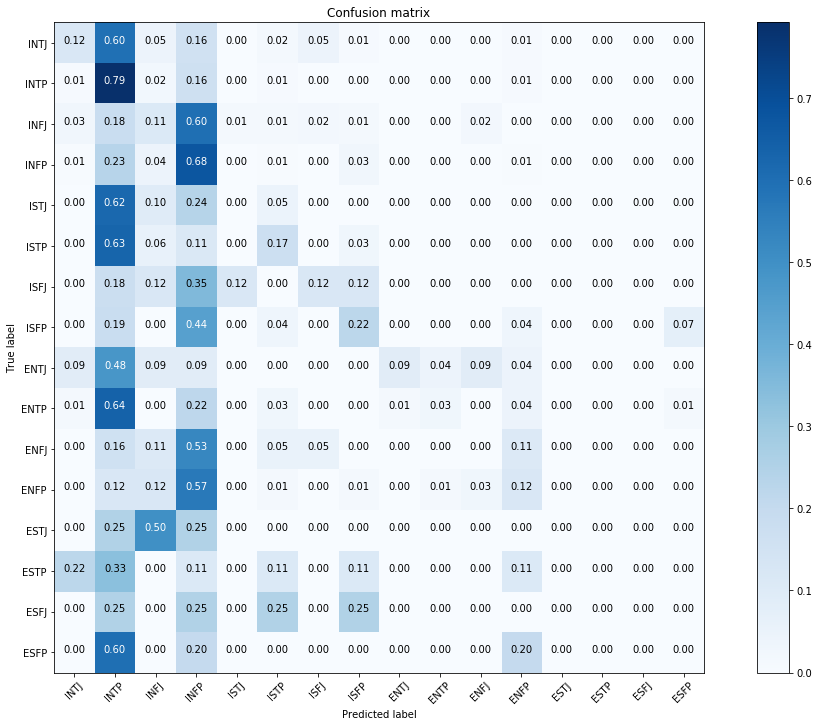

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

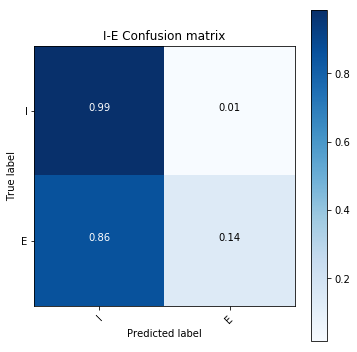

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

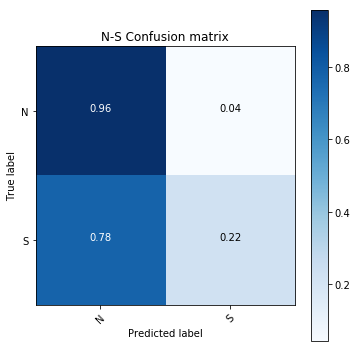

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

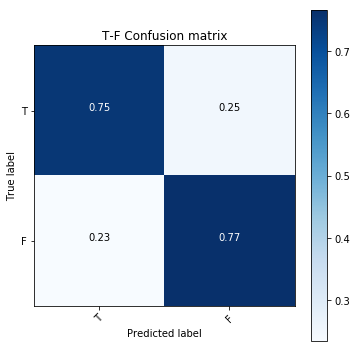

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

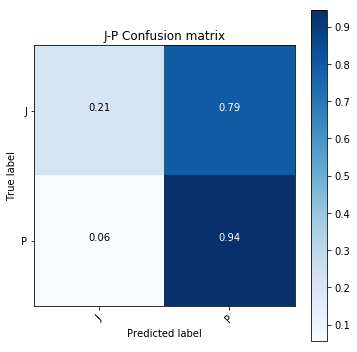

In [120]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import datetime

now = datetime.datetime.now()
pictures = []
folder = "FF"

def byte_to_mbti(byte):
    binary = ''
    for letter in byte:
         binary +=(str(int(letter)))        
    return type_dictionary[binary]

decoded_y_true = [byte_to_mbti(label) for label in y_test.round()]
decoded_y_pred = [byte_to_mbti(label) for label in y_pred.round()]

matrix = confusion_matrix(decoded_y_true, decoded_y_pred, labels=type_labels)
matrix_I_E = confusion_matrix(y_test[:,0], y_pred[:,0].round(), labels=[0, 1])
matrix_N_S = confusion_matrix(y_test[:,1], y_pred[:,1].round(), labels=[0, 1])
matrix_T_F = confusion_matrix(y_test[:,2], y_pred[:,2].round(), labels=[0, 1])
matrix_J_P = confusion_matrix(y_test[:,3], y_pred[:,3].round(), labels=[0, 1])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize=(15,10))
plot_confusion_matrix(matrix, classes=type_labels, normalize=True,
                      title='Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM0.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_I_E, classes=["I", "E"], normalize=True,
                      title='I-E Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM1.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_N_S, classes=["N", "S"], normalize=True,
                      title='N-S Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM2.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_T_F, classes=["T", "F"], normalize=True,
                      title='T-F Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM3.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_J_P, classes=["J", "P"], normalize=True,
                      title='J-P Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM4.png"
plt.savefig(name)
plt.show()
pictures.append(name)

In [121]:
def myprint(s):
    with open('results.log','a+') as f:
        print(s, file=f)
    f.close()
        
log_file = open('results.log', 'a+')

log_file.write("\n=================================================================")
log_file.write( "\n" + str(now.month) + "/" + str(now.day) + "/" + str(now.year) + " " + \
str(now.hour) + ":" + str(now.minute) + ":" + str(now.second) + "\n")

log_file.close()

model.summary(print_fn=myprint)

log_file = open('results.log', 'a+')

log_file.write("Results:\t" + str(results) + "\n")

log_file.write("Images:\n")
log_file.write("\t" + pictures[0] + "\n")
log_file.write("\t" + pictures[1] + "\n")
log_file.write("\t" + pictures[2] + "\n")
log_file.write("\t" + pictures[3] + "\n")
log_file.write("\t" + pictures[4] + "\n")

log_file.close()

In [41]:
import pandas as pd

df = pd.read_csv("mbti_1.csv", encoding="utf-8")
print("Number of users", len(df))

Number of users 8675


In [42]:
groups = df.groupby("type").count()

In [43]:
groups

,posts
type,
ENFJ,190
ENFP,675
ENTJ,231
ENTP,685
ESFJ,42
ESFP,48
ESTJ,39
ESTP,89
INFJ,1470
